In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from utils import train_and_plot_learning_curve
from sklearn.feature_selection import SequentialFeatureSelector
from ngboost import NGBRegressor

In [2]:
df = pd.read_csv('../data/features/train.csv', sep=';', index_col=0)

df['foundation_type'] = df['foundation_type'].astype('category')
df['concrete_code'] = df['concrete_code'].astype('category')
df['load_code'] = df['load_code'].astype('category')
df['wind_code'] = df['wind_code'].astype('category')
df['seismic_code'] = df['seismic_code'].astype('category')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1654 entries, 0 to 1653
Data columns (total 78 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   foundation_type             1654 non-null   category
 1   concrete_code               1654 non-null   category
 2   load_code                   1654 non-null   category
 3   wind_code                   1654 non-null   category
 4   seismic_code                1654 non-null   category
 5   floor_number                1654 non-null   int64   
 6   total_height                1654 non-null   float64 
 7   height                      1654 non-null   float64 
 8   foundation_height           1654 non-null   float64 
 9   double_height               1654 non-null   float64 
 10  triple_height               1654 non-null   float64 
 11  support_column              1654 non-null   int64   
 12  unsupported_column          1654 non-null   int64   
 13  walls_number      

## Preparando los datos

In [4]:
ngbr_cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan))

ngbr_default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"))

ngbr_preprocessing = ColumnTransformer([
        ("cat", ngbr_cat_pipeline, make_column_selector(dtype_include='category')),
    ],
    remainder=ngbr_default_num_pipeline,
    verbose_feature_names_out=False,
) 

# Datos de entrada

In [5]:
df = df.drop(['center_x', 'center_y', 'cdm_x', 'cdm_y', 'cdr_x', 'cdr_y'], axis=1)

In [6]:
X = df.drop("reinf_steel_ratio", axis=1)
y = df["reinf_steel_ratio"].copy()

In [7]:
len(X.columns)

71

In [8]:
X.columns

Index(['foundation_type', 'concrete_code', 'load_code', 'wind_code',
       'seismic_code', 'floor_number', 'total_height', 'height',
       'foundation_height', 'double_height', 'triple_height', 'support_column',
       'unsupported_column', 'walls_number', 'retaining_walls_number',
       'support_area', 'walls_area', 'retaining_walls_area', 'LL', 'DL',
       'LL_max', 'DL_max', 'wind_load_x', 'wind_load_y', 'seismic_acc',
       'slab_total_area', 'flat_slab_area', 'waffle_slab_area', 'depth',
       'drop_panel_area', 'domes_area', 'domes_number', 'inter_axis_distance',
       'shape_factor', 'x_length', 'y_length', 'concrete_m3_ratio',
       'slab_area_mean', 'height_mean', 'double_height_ratio',
       'triple_height_ratio', 'slenderness', 'column_area', 'swall_num',
       'swall_area', 'swall_area_mean', 'col_area_mean', 'rwalls_area_mean',
       'swall_area_mean_m2', 'col_area_mean_m2', 'rwalls_area_mean_m2',
       'swall_area_ratio', 'col_area_ratio', 'rwals_area_ratio', 

# Natural Gradient Boosting

In [13]:
ngbr_reg = make_pipeline(ngbr_preprocessing,
                           NGBRegressor()
                        ).set_output(transform="pandas")

In [14]:
ngbr_reg.fit(X, y)

[iter 0] loss=3.0272 val_loss=0.0000 scale=1.0000 norm=4.0688
[iter 100] loss=2.6466 val_loss=0.0000 scale=1.0000 norm=2.7960
[iter 200] loss=2.3866 val_loss=0.0000 scale=1.0000 norm=2.2352
[iter 300] loss=2.2005 val_loss=0.0000 scale=1.0000 norm=1.9463
[iter 400] loss=2.0586 val_loss=0.0000 scale=1.0000 norm=1.7565


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median'))]),
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f64e365f340>)],
                                   verbose_feature_names_out=False)),
                ('ngbregressor',
                 NGBRegressor(random_state=RandomState(MT19937) at 0x7F65601AB240))])

In [15]:
len(df.columns)

72

Text(0.5, 1.0, 'scale param')

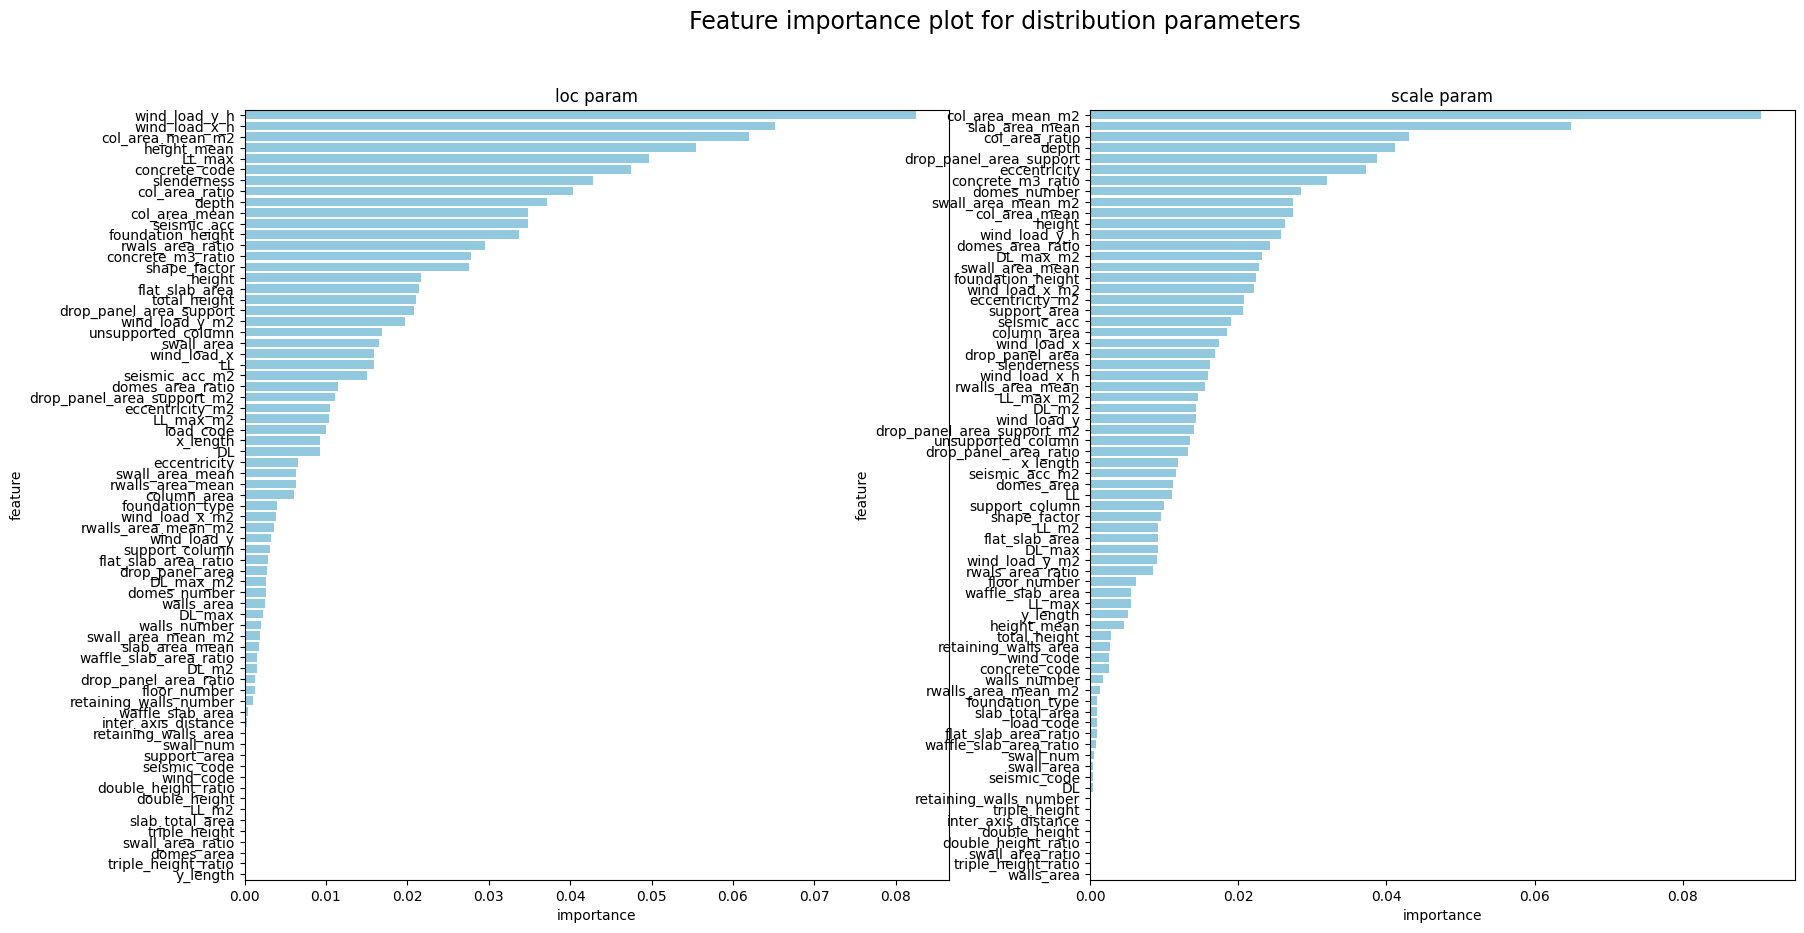

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_loc = pd.DataFrame({'feature': X.columns,
                       'importance': ngbr_reg['ngbregressor'].feature_importances_[0]})\
    .sort_values('importance',ascending=False)
df_scale = pd.DataFrame({'feature': X.columns,
                       'importance': ngbr_reg['ngbregressor'].feature_importances_[1]})\
    .sort_values('importance',ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle("Feature importance plot for distribution parameters", fontsize=17)
sns.barplot(x='importance',y='feature',ax=ax1,data=df_loc, color="skyblue").set_title('loc param')
sns.barplot(x='importance',y='feature',ax=ax2,data=df_scale, color="skyblue").set_title('scale param')

In [17]:
%%time
ngbr_reg_mapes = cross_val_score(ngbr_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

[iter 0] loss=3.0344 val_loss=0.0000 scale=1.0000 norm=4.0920
[iter 100] loss=2.6449 val_loss=0.0000 scale=2.0000 norm=5.5736
[iter 200] loss=2.3758 val_loss=0.0000 scale=2.0000 norm=4.3942
[iter 300] loss=2.1704 val_loss=0.0000 scale=1.0000 norm=1.8821
[iter 400] loss=2.0318 val_loss=0.0000 scale=1.0000 norm=1.7049
[iter 0] loss=3.0293 val_loss=0.0000 scale=1.0000 norm=4.0806
[iter 100] loss=2.6512 val_loss=0.0000 scale=2.0000 norm=5.6340
[iter 200] loss=2.3687 val_loss=0.0000 scale=2.0000 norm=4.4242
[iter 300] loss=2.1789 val_loss=0.0000 scale=1.0000 norm=1.9157
[iter 400] loss=2.0394 val_loss=0.0000 scale=1.0000 norm=1.7327
[iter 0] loss=3.0392 val_loss=0.0000 scale=1.0000 norm=4.1243
[iter 100] loss=2.6514 val_loss=0.0000 scale=1.0000 norm=2.8067
[iter 200] loss=2.3797 val_loss=0.0000 scale=1.0000 norm=2.2232
[iter 300] loss=2.1982 val_loss=0.0000 scale=1.0000 norm=1.9377
[iter 400] loss=2.0475 val_loss=0.0000 scale=1.0000 norm=1.7383
[iter 0] loss=3.0322 val_loss=0.0000 scale=1.0

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 107, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator,

In [18]:
ngbr_reg_mapes

array([0.10535689, 0.07809225, 0.10578672, 0.10538484, 0.10232587,
       0.10690019, 0.08597975, 0.09726546, 0.0999093 ,        nan])

In [19]:
pd.Series(ngbr_reg_mapes).describe()

count    9.000000
mean     0.098556
std      0.010059
min      0.078092
25%      0.097265
50%      0.102326
75%      0.105385
max      0.106900
dtype: float64

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

CPU times: user 1.46 s, sys: 1.55 s, total: 3.01 s
Wall time: 3min 23s


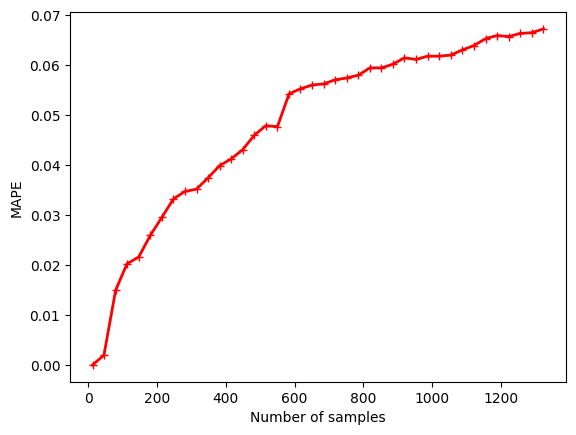

In [20]:
%%time
fig, ax = train_and_plot_learning_curve(ngbr_reg, X, y)
fig.savefig('../reports/figures/train/default_ngbr_cv.pdf', bbox_inches='tight')

# Grid Search

In [23]:
%%time

from sklearn.tree import DecisionTreeRegressor
from ngboost.distns import Exponential, Normal

b1 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
b2 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=4)
b3 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=6)


ngbr_reg = make_pipeline(ngbr_preprocessing,
                         NGBRegressor(Dist=Normal, verbose=False)
                        ).set_output(transform="pandas")

parameters = {
 'ngbregressor__minibatch_frac': [1.0, 0.5],
 'ngbregressor__Base' : [b1, b2, b3],
 }

#instantiate the gridsearch
ngbr_grid = GridSearchCV(ngbr_reg, parameters, n_jobs=-1, cv=10, scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))
#fit on the grid 
ngbr_grid.fit(X, y)

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

CPU times: user 10.2 s, sys: 101 ms, total: 10.3 s
Wall time: 1min 56s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median'))]),
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan))]),
                                                                         <s...
                                                     verbose=False))]),
             n_jobs=-1,
             param_grid={'ngbregressor__Base': [DecisionTreeRegressor(criterion='friedman_mse',
                                                                      max_depth=2),
                                                DecisionTreeRegressor(criterion='friedman_mse',
                                                                      max_depth=4),
                                                DecisionTreeRegressor(criterion='friedman_mse',
                                                                      max_depth=6)],
                         'ngbregressor__minibatch_frac': [1.0, 0.5]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [24]:
ngbr_grid.best_params_

{'ngbregressor__Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2),
 'ngbregressor__minibatch_frac': 1.0}

# Best Model

In [26]:
best_params = {key.split('__')[-1]: value for key, value in ngbr_grid.best_params_.items()}
best_params

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2),
 'minibatch_frac': 1.0}

In [27]:
%%time
categorical_columns = X.select_dtypes(include="category").columns
ngbr_reg = make_pipeline(ngbr_preprocessing,
                         NGBRegressor(Dist=Normal, verbose=False, **best_params)
                        ).set_output(transform="pandas")
ngbr_reg_mapes = cross_val_score(ngbr_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)
pd.Series(ngbr_reg_mapes).describe()

CPU times: user 1min 32s, sys: 11.4 ms, total: 1min 32s
Wall time: 1min 32s


/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 107, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator,

count    9.000000
mean     0.110104
std      0.011125
min      0.089606
25%      0.101144
50%      0.115248
75%      0.115476
max      0.122386
dtype: float64

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/pab

CPU times: user 1.22 s, sys: 1.11 s, total: 2.33 s
Wall time: 2min 45s


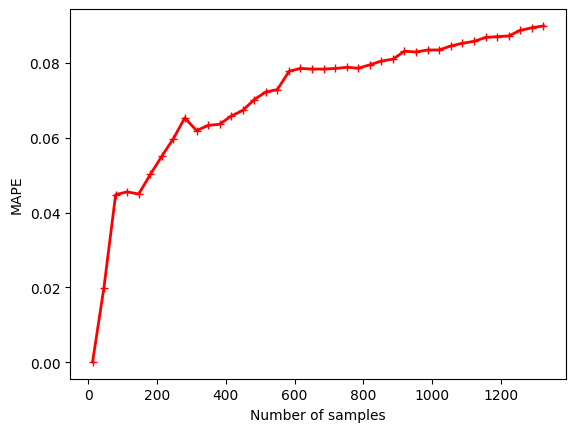

In [28]:
%%time
fig, ax = train_and_plot_learning_curve(ngbr_reg, X, y)
fig.savefig('../reports/figures/train/best_ngbr_cv.pdf', bbox_inches='tight')